In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array, dot, arccos, clip
from numpy.linalg import norm


In [17]:
# rotation about Z axis

def rotatonMatrixZ(theta):
    
    theta = np.deg2rad(theta)
    ct = np.cos(theta)
    st = np.sin(theta)
    
    return np.matrix([ct, -st, 0 , st, ct, 0, 0, 0, 1]).reshape(3,3)



def rotationMatrixX(theta):
    
    theta = np.deg2rad(theta)
    ct = np.cos(theta)
    st = np.sin(theta)
    
    return np.matrix([1, 0, 0, 0, ct, -st, 0, st, ct]).reshape(3,3)






#coordinate of hydrogen atoms with respect to oxygen atom at position (0,0,0) and the dipole vector oriented
# at an angle given by angle

def h1Inh20(angle): # angle is orientation angle with the horizontal plane
    phi = 90-angle
    theta = np.deg2rad(90 - 52.25)
    d = 0.96
    st = np.sin(theta)
    ct = np.cos(theta)
    
    R = rotationMatrixX(phi)
    x = d * st 
    y = 0
    z = d * ct 
    
    hydrogen_1 = np.matmul(R, np.matrix([x, y, z]).T)
    hydrogen_2 = np.matmul(R, np.matrix([-x, y, z]).T)
    
    return hydrogen_1,\
           hydrogen_2 

    
    
    
    
def dipoleVector(angle): # angle with the horizontal plane
    phi = 90-angle
    R = rotationMatrixX(phi)
    return np.matmul(R, np.matrix([0, 0, -1]).T)




# r1 is row vector and r2 is row vectors   
def distanceR12(r1,r2):
    return np.linalg.norm((r1-r2).T)
    #r = r1 - r2
    #return np.sqrt( r * r.T)[0,0]



def angle(r1, r2):
    c = dot(r1,r2.T)/norm(r1)/norm(r2) # -> cosine of the angle
    angle = arccos(clip(c, -1, 1)) # if you really want the angle
    return np.rad2deg(angle)



def nearest_list(pos, threshold):
    list_near = []
    for pos1_index in range(len(pos)):
        dist_small = np.inf
        dist = np.inf
        near_list = []
        for pos2_index in range(len(pos)):
            if pos1_index == pos2_index:
                dist = np.inf
            else:
                dist = distanceR12(pos[pos1_index], pos[pos2_index])
                
            if (dist < dist_small and abs(dist - dist_small) > threshold):
                near_list.clear()
                dist_small = dist
                near_list.append(pos2_index)
                
            elif dist - dist_small < threshold:
                near_list.append(pos2_index)
            else:
                pass
        list_near.append(near_list)
        
    return list_near



def unit(r):
    return r/np.linalg.norm(r.T)


## Siepmann's model for Pt-H20 interaction

### Two body interaction between O in H20 and Pt

\begin{equation}
v_2(r_{ij}) = A r^{-\alpha}_{ij} - C r^{-6}_{ij} - D f_2(r_{ij}) r_{ij}^{-3}\Phi_{ij}(\phi_{ij})
\end{equation}
where $r_{ij}$ is the distance between th oxygen site of given water molecule $i$ and metal atom $j$. And $\phi_{ij}$ is the angle between dipole vector and oxygen-metal bond vector $\textbf{r}_{ij}$

$$f_2(r) = \exp\left[\frac{B}{r-r_{cut}}\right]$$ for $r$< $r_{cut}$ and $f_2(r)=0$ for $r\geq r_{cut}$.
The functional form for $\Phi$ is
\begin{equation}
\Phi(\phi) = \exp\left[-8\left(\frac{\cos\phi-1}{4}\right)^4 \right]
\end{equation}

### The three body term to push the oxygen to atop site is 
\begin{equation}
v_3(\textbf{r}_i,\textbf{r}_j,\textbf{r}_k) = E f_2(r_{ij})r_{ij}^{-\beta}\exp\left[F\cos^2\left(\frac{\theta_{ijk}}{2}\right)\right]
\end{equation}
where $\theta_{ijk}$ is the angle between oxygen-metal bond $\textbf{r}_{ij}$ and a metal-metal bond $\textbf{r}_{kj}$

In [18]:
def two_body(r_pt, r_oxygen, dipole_vector):
    A = 1.7e5
    C = 1.7e3
    D = 1.435e3
    r_o_pt = (r_pt - r_o)
    r = norm(r_o_pt)
    
    dipole_angle = angle(r_o_pt, dipole_vector)
    potential_two = A/r**11 - C/r**6 
    potential = potential_two - (D*f(r)/r**3)*phi(dipole_angle[0,0]) # dipole angle is the orientation angle
    return potential


def f(r):
    B = 0.6
    r_cut = 3.2
    if r < r_cut:
        return np.exp(B/(r - r_cut))
    else:
        return 0
    
#angle is in degree    
def phi(angle):
    angle = np.deg2rad(angle)
    argument = -8*( ( np.cos(angle)-1 )/4 )**4
    #argument = -8*( ( np.cos(angle)-1 )/4 )**4
    return np.exp(argument)


def three_body(r_support_m, r_neighbor_m, r_o):
    E = 4.1e1
    F = 13.3
    r = norm(r_support_m - r_o)
    three_body_angle = angle((r_support_m - r_neighbor_m), (r_support_m - r_o))
    
    three_body_angle = np.deg2rad(three_body_angle)
    three_body_potential = E * f(r) * r**-10 * np.exp(F * np.cos(three_body_angle/2)**2)
    return three_body_potential 


def force_two_body(r_pt, r_oxygen, dipole_vector):
    A = 1.7e5
    C = 1.7e3
    D = 1.435e3
    B = 0.6
    r_cut = 3.2
    r_o_pt = (r_pt - r_o)
    r = norm(r_o_pt)
    direction = -unit(r_o_pt)
    dipole_angle = angle(r_o_pt, dipole_vector)
    
    force_two = -(-11 * (A/r**12) + 6 * (C/r**7) + (D/r**3) * (3/r + B/(r-r_cut)**2) * f(r) * phi(dipole_angle[0,0]))
    
    return force_two * direction


def force_three_body(r_support_m, r_neighbor_m, r_o):
    E = 4.1e1
    F = 13.3
    B = 0.6
    r_cut = 3.2
    r = norm(r_support_m - r_o)
    direction = -unit(r_support_m - r_o)
    three_body_angle = angle((r_support_m - r_neighbor_m), (r_support_m - r_o))
    
    three_body_angle = np.deg2rad(three_body_angle)
    force_three = -(-E * f(r)/r**10 * ( 10/r + B/(r - r_cut)**2 ) * np.exp(F * np.cos(three_body_angle/2)**2))
    return force_three * direction

## Interaction between platinum and oxygen of water
$$V_{PtO} = \frac{A}{r^m} - \frac{B}{r^n} - \frac{C}{r^p}$$


## Force on Oxygen due to Platinum atom
$$\textbf{F} = - \left[-m\frac{A}{r^{m+1}} + n \frac{B}{r^{n+1}} + p \frac{C}{r^{p+1}}\right]\hat{\textbf{r}}_{Pt-O}$$

In [19]:
def PtO_potential(r_pt, r_o, A, B , C, m, n, p):
    r_o_pt = r_pt - r_o
    r = norm(r_o_pt)
    potential = A/r**m - B/r**n - C / r**p
    return potential


def PtO_force (r_pt, r_o, A, B, C, m, n, p):
    r_o_pt = r_pt - r_o
    r = norm(r_o_pt)
    direction = -unit(r_o_pt)
    force = -(-m*A/r**(m+1) + n*B/r**(n+1) + p*C / r**(p+1))
    return force * direction

## Interaction between platinum and Hydrogen of water
$$V_{PtH} = \frac{D}{r^q} + \frac{E}{r^s} + \frac{F}{r^t}$$


## Force on Hydrogen due to Platinum atom
$$\textbf{F} = - \left[-q\frac{D}{r^{q+1}} - s \frac{E}{r^{s+1}} - t \frac{F}{r^{t+1}}\right]\hat{\textbf{r}}_{Pt-H}$$

In [20]:
def PtH_potential(r_pt, r_H, D, E, F, q, s, t):
    r_H_pt = r_pt - r_H
    r = norm(r_H_pt)
    potential = D/r**q + E/r**s + F / r**t
    return potential


def PtH_force (r_pt, r_H, D, E, F, q, s, t):
    r_H_pt = r_pt - r_H
    r = norm(r_H_pt)
    direction = -unit(r_H_pt)
    force = -(-q*D/r**(q+1) - s*E/r**(s+1) + t*F / r**(t+1))
    return force * direction

## Coordinates of Pt atoms

In [21]:
# differernt configurations



inputFile =  "../FDEAMCrystalCalculations/PtCoord.dat"
fileInput = open(inputFile)
lines = fileInput.readlines()
coord=[]
for line in lines:
    pos = str.split(line)
    coord.append([float(pos[0]),float(pos[1]),float(pos[2])])
fileInput.close()
position = np.array(coord)

## Coordinates of Pt atoms centered around atop site 

In [22]:
# atop configuration
atop_pos = position - np.array([[-2.000417,0.692965,12.447672]])
distance = np.arange(1,5,.1)
orientation = np.arange(-90,95,5)
rotate_angle = np.arange(0,360,45)


In [23]:
atop_pt_surf = atop_pos[atop_pos[:,2]==0]
atop_pt_bottom = atop_pos[atop_pos[:,2] != 0]

surf_near_list = nearest_list(atop_pt_surf,0.01)

In [24]:
configuration= [[dist, ang_phi, ang_theta] for dist in distance for ang_phi in rotate_angle for ang_theta in orientation]

In [28]:



atop = open("../FDEAMCrystalCalculations/atop_data1.dat",'w')
atop.write("#sn\t\tdist\t\torientation\t\tphi\t\tenergy(kJ/mol)\n")
atop.close()

atop_force = open("../FDEAMCrystalCalculations/atop_force_data1.dat",'w')
atop_force.write("#sn\t\tdist\t\torientation\t\tphi\t\tFx\t\tFy\t\tFz\n")
atop_force.close()

count = 0
for config in [[2.34,0,-90]]:
    d, p, t = config
    r_o = np.array([0,0,d])
    dipole_vector = -dipoleVector(t)
    Rz = rotatonMatrixZ(p)
    dipole_vector = np.matmul(Rz, dipole_vector)
    energy = 0
    force = np.array([0.0,0.0,0.0])
    
    
    for r_m in atop_pos:
        energy += two_body(r_m, r_o, dipole_vector.T)
        force += force_two_body(r_m, r_o, dipole_vector.T)
    print(energy)
    
    for r_n_index in range(len(atop_pt_surf)):
        for r_s_index in surf_near_list[r_n_index] :
            r_n = atop_pt_surf[r_n_index]
            r_s = atop_pt_surf[r_s_index]
            
            energy_three= three_body(r_s, r_n, r_o)
            print(energy_three)
            energy += energy_three
            force += force_three_body(r_s, r_n , r_o)
    count += 1
    atop = open("../FDEAMCrystalCalculations/atop_data1.dat",'a')
    atop.write("%d\t\t%f\t\t%f\t\t%f\t\t%f\n"%(count,d,t,p,energy))
    atop.close()
    
    atop_force = open("../FDEAMCrystalCalculations/atop_force_data1.dat",'a')
    atop_force.write("%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f\n"%(count,d,t,p,force[0], force[1], force[2]))
    atop_force.close()

-56.70979339499857
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.2039625941509717
0.0
0.0
0.0
0.0
0.0
3.2039625941509717
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.2039625941509717
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.2039625941509717
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.2039625941509717
0.0
0.0
0.0
0.0
3.2039625941509717
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [29]:
energy,force

(-37.486017830092734,
 array([-1.57861830e-08,  5.92880919e-07,  1.94565014e+01]))

## Coordinates of Pt atoms centered around hollow site 

In [25]:
## for hollow site
# the coordinates of vertices of triangle is
# [-2.000417,0.692965,12.447672]
# [-2.000417,3.464823,12.447672]
# [0.400083, 2.078894, 12.447672]

v1 = np.array([[-2.000417,0.692965,12.447672]])
v2 = np.array([[-2.000417,3.464823,12.447672]])
v3 = np.array([[0.400083, 2.078894, 12.447672]])
centroid = (v1+v2+v3)/3
print(centroid)

[[-1.20025033  2.078894   12.447672  ]]


In [26]:
hollow_pos = position - np.array([[-1.20025033,  2.078894,   12.447672  ]])
distance = np.arange(1,5,.1)
orientation = np.arange(-90,95,5)
rotate_angle = np.arange(0,360,45)

In [27]:
hollow_pt_surf = atop_pos[atop_pos[:,2]==0]
hollow_pt_bottom = atop_pos[atop_pos[:,2] != 0]
surf_near_list = nearest_list(hollow_pt_surf,0.01)

In [12]:
configuration = [[dist, ang_phi, ang_theta] for dist in distance for ang_phi in rotate_angle for ang_theta in orientation]

In [829]:
hollow = open("../FDEAMCrystalCalculations/hollow_data1.dat",'w')
hollow.write("#sn\t\tdist\t\torientation\t\tphi\t\tenergy(kJ/mol)\n")
hollow.close()

hollow_force = open("../FDEAMCrystalCalculations/hollow_force_data1.dat",'w')
hollow_force.write("#sn\t\tdist\t\torientation\t\tphi\t\tFx\t\tFy\t\tFz\n")
hollow_force.close()

count = 0
for config in [[2.38, 0, 90]]:
    d, p, t = config
    r_o = np.array([0,0,d])
    dipole_vector = dipoleVector(t)
    Rz = rotatonMatrixZ(p)
    dipole_vector = np.matmul(Rz, dipole_vector)
    energy = 0
    force = np.array([0.0,0.0,0.0])
    for r_m in hollow_pos:
        energy += two_body(r_m, r_o, dipole_vector.T)
        force += force_two_body(r_m, r_o, dipole_vector.T)
        
    for r_n_index in range(len(hollow_pt_surf)):
        for r_s_index in surf_near_list[r_n_index] :
            r_n = hollow_pt_surf[r_n_index]
            r_s = hollow_pt_surf[r_s_index]
            
            energy_three= three_body(r_s, r_n, r_o)
            energy += energy_three
            force += force_three_body(r_s, r_n , r_o)
    count += 1
    hollow = open("../FDEAMCrystalCalculations/hollow_data1.dat",'a')
    hollow.write("%d\t\t%f\t\t%f\t\t%f\t\t%f\n"%(count,d,t,p,energy))
    hollow.close()
    
    hollow_force = open("../FDEAMCrystalCalculations/hollow_force_data1.dat",'a')
    hollow_force.write("%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f\n"%(count,d,t,p,force[0], force[1], force[2]))
    hollow_force.close()

In [767]:
print(energy)

-18.34846400667371


## Coordinates of Pt atoms centered around bridge site 

In [28]:
# bridge site
# the coordinates of ends of line are
# [-2.000417,0.692965,12.447672]
# [-2.000417,3.464823,12.447672]


v1 = np.array([[-2.000417,0.692965,12.447672]])
v2 = np.array([[-2.000417,3.464823,12.447672]])
mid_point = (v1 + v2)/2
print(mid_point)

[[-2.000417  2.078894 12.447672]]


In [29]:
bridge_pos = position - np.array([[-2.000417,  2.078894, 12.447672]])
distance = np.arange(1,5,.1)
orientation = np.arange(-90,95,5)
rotate_angle = np.arange(0,360,45)

In [30]:
bridge_pt_surf = atop_pos[atop_pos[:,2]==0]
bridge_pt_bottom = atop_pos[atop_pos[:,2] != 0]
surf_near_list = nearest_list(bridge_pt_surf,0.01)

In [31]:
configuration = [[dist, ang_phi, ang_theta] for dist in distance for ang_phi in rotate_angle for ang_theta in orientation]

In [835]:
bridge = open("../FDEAMCrystalCalculations/bridge_data1.dat",'w')
bridge.write("#sn\t\tdist\t\torientation\t\tphi\t\tenergy(kJ/mol)\n")
bridge.close()


bridge_force = open("../FDEAMCrystalCalculations/bridge_force_data1.dat",'w')
bridge_force.write("#sn\t\tdist\t\torientation\t\tphi\t\tFx\t\tFy\t\tFz\n")
bridge_force.close()

count = 0
for config in configuration:
    d, p, t = config
    r_o = np.array([0,0,d])
    dipole_vector = dipoleVector(t)
    Rz = rotatonMatrixZ(p)
    dipole_vector = np.matmul(Rz, dipole_vector)
    energy = 0
    force = np.array([0.0,0.0,0.0])
    for r_m in bridge_pos:
        energy += two_body(r_m, r_o, dipole_vector.T)
        force += force_two_body(r_m, r_o, dipole_vector.T)
    for r_n_index in range(len(bridge_pt_surf)):
        for r_s_index in surf_near_list[r_n_index] :
            r_n = bridge_pt_surf[r_n_index]
            r_s = bridge_pt_surf[r_s_index]
            
            energy_three= three_body(r_s, r_n, r_o)
            energy += energy_three
            force += force_three_body(r_s, r_n , r_o)
    count += 1
    bridge = open("../FDEAMCrystalCalculations/bridge_data1.dat",'a')
    bridge.write("%d\t\t%f\t\t%f\t\t%f\t\t%f\n"%(count,d,t,p,energy))
    bridge.close()
    
    
    bridge_force = open("../FDEAMCrystalCalculations/bridge_force_data1.dat",'a')
    bridge_force.write("%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f\n"%(count,d,t,p,force[0], force[1], force[2]))
    bridge_force.close()


# Analyze the data for Siepmann's forcefield for water.

In [32]:
# get the data at atop position
from ipykernel import kernelapp as app
data_atop_force = pd.read_csv("../FDEAMCrystalCalculations/atop_force_data.dat",sep='\t\t',skiprows = 1,usecols= [1,2,3,4,5,6],names=['d','theta','phi','fx','fy','fz'])
data_bridge_force = pd.read_csv("../FDEAMCrystalCalculations/bridge_force_data.dat",sep='\t\t',skiprows = 1,usecols= [1,2,3,4,5,6],names=['d','theta','phi','fx','fy','fz'])
data_hollow_force = pd.read_csv("../FDEAMCrystalCalculations/hollow_force_data.dat",sep='\t\t',skiprows = 1,usecols= [1,2,3,4,5,6],names=['d','theta','phi','fx','fy','fz'])


/home/hbhattar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()
/home/hbhattar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/home/hbhattar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [33]:
total_config = data_atop_force.shape[0]

In [34]:
def chiSqureError(A, B, C, D, E, F):
    chi_error = 0;
    for index in range(total_config):
        small_number = 1e-10
        dist, theta, phi, tfxr, tfyr, tfzr = data_atop_force.iloc[index]
        dist, theta, phi, hfxr, hfyr, hfzr = data_hollow_force.iloc[index]
        dist, theta, phi, bfxr, bfyr, bfzr = data_bridge_force.iloc[index]
        r_o = np.array([0,0,dist])
        R = rotatonMatrixZ(phi)
        hydrogen_1, hydrogen_2 = h1Inh20(theta)

        hydrogen_1 = np.array(np.matmul(R, hydrogen_1)).T[0]

        hydrogen_2 = np.array(np.matmul(R, hydrogen_2)).T[0]


        hydrogen_1 = hydrogen_1 + r_o
        hydrogen_2 = hydrogen_2 + r_o


        # atop position:
        force = np.array([0.0,0.0,0.0])
        for r_m in atop_pos:
            force += PtO_force(r_m, r_o, A, B, C, 11, 6, 3)
            force += PtH_force(r_m, hydrogen_1, D, E, F, 10, 6, 3)
            force += PtH_force(r_m, hydrogen_2, D, E, F, 10, 6, 3)


        chi_error += ((tfxr + small_number - force[0])/(tfxr+small_number))**2 +\
                    ((tfyr + small_number - force[1])/(tfyr+small_number))**2 + \
                    ((tfzr + small_number - force[2])/(tfzr+small_number))**2

        force = np.array([0.0,0.0,0.0])
        for r_m in bridge_pos:
            force += PtO_force(r_m, r_o, A, B, C, 11, 6, 3)
            force += PtH_force(r_m, hydrogen_1, D, E, F, 10, 6, 3)
            force += PtH_force(r_m, hydrogen_2, D, E, F, 10, 6, 3)

        chi_error += ((bfxr + small_number - force[0])/(bfxr+small_number))**2 +\
                    ((bfyr + small_number - force[1])/(bfyr+small_number))**2 +\
                    ((bfzr + small_number - force[2])/(bfzr+small_number))**2

        force = np.array([0.0,0.0,0.0])
        for r_m in hollow_pos:
            force += PtO_force(r_m, r_o, A, B, C, 11, 6, 3)
            force += PtH_force(r_m, hydrogen_1, D, E, F, 10, 6, 3)
            force += PtH_force(r_m, hydrogen_2, D, E, F, 10, 6, 3)

        chi_error += ((hfxr + small_number - force[0])/(hfxr + small_number ))**2 +\
                    ((hfyr + small_number - force[1])/(hfyr + small_number ))**2 + \
                    ((hfzr + small_number - force[2])/(hfzr + small_number ))**2
    return chi_error

In [71]:
A = [1.7e5]
B = [1.7e3]
C = [1.435e3]
D = [152716.00]
E = [-7280.16]
F = [548.104]

err_file = open("../FDEAMCrystalCalculations/params_chi_error_new.dat",'w')
err_file.write("#a,b,c,d,e,f,error\n")
err_file.close()

parameters = [[a,b,c,d,e,f] for a in A for b in B for c in C for d in D for e in E for f in F]
for params in parameters:
    a,b,c,d,e,f = params
    error = chiSqureError(a, b, c, d, e, f)
    
    
    err_file = open("../FDEAMCrystalCalculations/params_chi_error_new.dat",'a')
    err_file.write("%f,%f,%f,%f,%f,%f,%f\n"%(a,b,c,d,e,f,error))
    err_file.close()


In [68]:
chi_error_data = pd.read_csv("../FDEAMCrystalCalculations/chi_param.dat", sep = ',', skiprows=1\
        ,names=['A','B','C','D','E','F','error'])

In [72]:
chi_error_data[chi_error_data.error == min(chi_error_data.error)]

,A,B,C,D,E,F,error
0,170000.0,1700.0,1435.0,10.0,-10.0,10.0,1.402818e+24


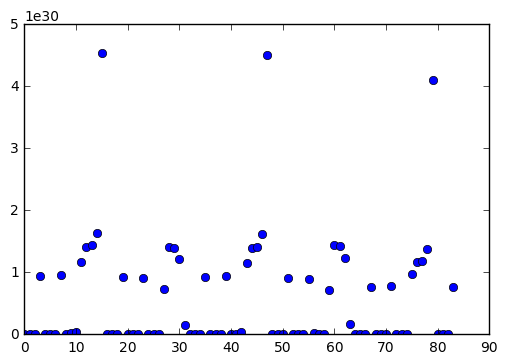

In [70]:
plt.plot(chi_error_data.error,'o')
plt.show()

In [73]:
data_atop_force

,d,theta,phi,fx,fy,fz
0,1.0,-90.0,0.0,-0.0,-0.003458,3.322366e+06
1,1.0,-85.0,0.0,-0.0,-0.462287,3.322366e+06
2,1.0,-80.0,0.0,-0.0,-0.963304,3.322366e+06
3,1.0,-75.0,0.0,-0.0,-1.547002,3.322366e+06
4,1.0,-70.0,0.0,-0.0,-2.250395,3.322366e+06
5,1.0,-65.0,0.0,-0.0,-3.105103,3.322367e+06
6,1.0,-60.0,0.0,-0.0,-4.135362,3.322367e+06
7,1.0,-55.0,0.0,-0.0,-5.356107,3.322368e+06
8,1.0,-50.0,0.0,-0.0,-6.771361,3.322369e+06
9,1.0,-45.0,0.0,-0.0,-8.373221,3.322370e+06


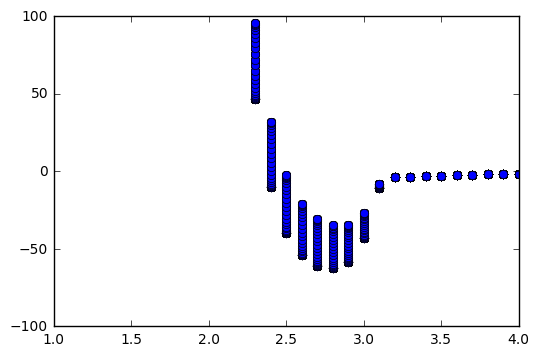

In [84]:
plt.plot(data_atop_force.d,data_atop_force.fz,'o')
plt.ylim([-100,100])
plt.xlim([1,4])
plt.show()

In [85]:
data_atop_ene = pd.read_csv("../FDEAMCrystalCalculations/atop_data.dat",sep='\t\t',skiprows = 1,usecols= [1,2,3,4,5,6],names=['d','theta','phi','energy'])
data_bridge_ene = pd.read_csv("../FDEAMCrystalCalculations/bridge_data.dat",sep='\t\t',skiprows = 1,usecols= [1,2,3,4,5,6],names=['d','theta','phi','energy'])
data_hollow_ene = pd.read_csv("../FDEAMCrystalCalculations/hollow_data.dat",sep='\t\t',skiprows = 1,usecols= [1,2,3,4,5,6],names=['d','theta','phi','energy'])


/home/hbhattar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


ValueError: Number of passed names did not match number of header fields in the file